# Assigment 5

## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Classification

In [880]:
# Download the LIBSVM package from here: https://www.csie.ntu.edu.tw/~cjlin/libsvm/#download 
# If your download is successfull you should have the folder with name: libsvm-3.24.
# We will use this package to load datasets. 

# Enter the downloaded folder libsvm-3.24 through your terminal. 
# Run make command to compile the package.

# Load this auxiliary package.
import sys

# add here your path to the folder libsvm-3.24/python
path = "/home/tempo/Desktop/Fall 2019/CS 794/a5/libsvm-3.24/python"
# Add the path to the Python paths so Python can find the module.
sys.path.append(path)

# Load the LIBSVM module.
from svmutil import *

# Add here your path to the folder libsvm-3.24
path = "/home/tempo/Desktop/Fall 2019/CS 794/a5/libsvm-3.24"

# Test that it works. This will load the data "heart_scale" 
# and it will store the labels in "b" and the data matrix in "A".
b, A = svm_read_problem(path + '/heart_scale')
print('Loaded data: Heart Scale')
# Use "svm_read_problem" function to load data for your assignment.

# Note that matrix "A" stores the data in a sparse format. 
# In particular matrix "A" is a list of dictionaries. 
# The length of the list gives you the number of samples.
# Each entry in the list is a dictionary. The keys of the dictionary are the non-zero features.
# The values of the dictionary for each key is a list which gives you the feature value. 

Loaded data: Heart Scale


In [881]:
import matplotlib.pyplot as plt

# Numpy is useful for handling arrays and matrices.
import numpy as np
from scipy.sparse import coo_matrix
import time
from random import randrange as rnd
import sklearn
import sklearn.metrics
import random
import pandas as pd

In [882]:
path_news20 = r'/home/tempo/Desktop/Fall 2019/CS 794/a5/news20.binary'
b_news20, A_news20 = svm_read_problem(path_news20) #(19996, 1355191)

def splitData(A, b):
    n = A.shape[0]
    test_split = 15996
    valid_split = 2000
    train_split = 2000
   
    ATrain = A[0 : test_split]
    bTrain = b[0 : test_split]
    
    AValid = A[test_split : test_split + valid_split]
    bValid = b[test_split : test_split + valid_split]
    
    ATest = A[n - train_split :]
    bTest = b[n - train_split :]
    
    return ATrain, AValid, ATest, bTrain, bValid, bTest

def toSparse(A, cols):
    row = []
    col = []
    data = []
    for i in range(len(A)):
        for key, val in A[i].items():
            row.append(i)
            col.append(key - 1)
            data.append(val)
    return coo_matrix((data, (row, col)), shape=(len(A), cols)).tocsr()

def bConverter(b):
    for i in range(len(b)):
        if (b[i] == 2):
            b[i] = -1
    return b

A_news20 = toSparse(A_news20, 1355191)
b_news20 = np.array(b_news20)
b_news20 = b_news20.reshape((b_news20.shape[0], 1))
print(A_news20.shape)

ATrain_news20, AValid_news20, ATest_news20, bTrain_news20, bValid_news20, bTest_news20 = splitData(A_news20, b_news20)

print('News data set loaded')

(19996, 1355191)
News data set loaded


In [883]:
initParams = {
    'lambda_': 0.001,
    'epsilon': 1e-2,
    'max_iter': 2000,
    'alpha0': 1,
    't': 1,
    'beta0': np.random.uniform(-0.5, 0.5),
    'theta': 0.5,
    'x0_news20': np.random.uniform(-1, 1, size = (ATrain_news20.shape[1], 1)),
    'sigma': 1e-12,
    'delta': 1e-12
}

In [884]:
proxGradData = []
accelProxGradData = []

Download the dataset 
    news20.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#news20.binary
Check Assignment 4 for instructions about loading this dataset.

Question 1
-------------

Solve the l1-regularized logistic regression problem
$$\mbox{minimize}_{x\in\mathbb{R}^d,\beta\in\mathbb{R}} \ \lambda \|x\|_1 + \frac{1}{n} \sum_{i=1}^n \log (1+ \exp(-b_i(a_i^Tx + \beta)))$$
using 

1) Proximal gradient descent

2) Accelerated proximal gradient descent

3) Proximal coordinate descent

4) Accelerated proximal coordinate descent

Tune the model parameter $\lambda$ and any parameters that the algorithms have. You only have to tune $\lambda$ once and use the same $\lambda$ for all algorithms. Use similar techniques to Assignment 4 to tune $\lambda$. Plot the objective function (y-axis) vs running time in sec (x-axis) for all algorithms in the same plot. Make sure that the plots are clean and use appropriate legends. Report your generalization error. This should be measured in the same way as Assignment 4.

For training split the data into training (the first 15996 datapoints), validation (the next 2000 datapoints) and testing (the next 2000 datapoints). Do not use the testing data to influence training in any way. This means that you should compute the generalization error only once when you finish your work with this part of the assignment.

Marks: 15

In [885]:
def lineSearch(beta, xCurrent, gradF, A, b):
    lambda_ = initParams['lambda_']
    alpha = initParams['alpha0']
    theta = initParams['theta']
    logisticRegression = LogisticRegression()
    proxGradDesc = ProxGradDesc()
    
    #Compute F(x(alpha)):
    x_alpha = proxGradDesc.proxAG(alpha, xCurrent, gradF)
    F_x_alpha = logisticRegression.objFunc(x_alpha, A, b, beta)
    
    #Compute F(x_k):
    F_x_k = logisticRegression.objFunc(xCurrent, A, b, beta)
    
    #Compute theta * (l(x_k) - l(x(alpha))):
    l_x_k = F_x_k
    l_x_alpha = logisticRegression.gx(x_alpha) + logisticRegression.fx(xCurrent, A, b, beta) + np.dot(gradF.T, x_alpha - xCurrent)
    
    while (F_x_alpha > F_x_k - theta * (l_x_k - l_x_alpha)):
        alpha /= 2
        
        #Compute F(x(alpha)):
        x_alpha = proxGradDesc.proxAG(alpha, xCurrent, gradF)
        F_x_alpha = logisticRegression.objFunc(x_alpha, A, b, beta)
        l_x_alpha = logisticRegression.gx(x_alpha) + logisticRegression.fx(xCurrent, A, b, beta) + np.dot(gradF.T, x_alpha - xCurrent)
    
    return alpha

def validationError(bTrue, bPredict):
    t = len(bTrue)
    totalError = 0
    for i in range (t):
        totalError += np.abs(bPredict[i] - bTrue[i])
    return totalError / (2 * t)

def calcAccuracy(bTrue, bPredict):
    return 1 - .5 * validationError(bTrue, bPredict)

In [886]:
class LogisticRegression(object):
    
    def __init__(self):
        self.lambda_ = initParams["lambda_"]
        
    def __str__(self):
        return 'L1-regularized Logistic Regression'  
    
    def gx(self, x):
        lambda_ = self.lambda_
        return lambda_ * np.linalg.norm(x, 1)
    
    def fx(self, x, A, b, beta):
        n = A.shape[0]
        aTx = A @ x
        sumLogistic = sum(np.log(1 + np.exp(-b * (aTx + beta))))
        return sumLogistic / n
    
    def objFunc(self, x, A, b, beta):
        g_x = self.gx(x)
        f_x = self.fx(x, A, b, beta)
        return g_x + f_x
    
    def gradient(self, x, A, b, beta):
        n = A.shape[0]
        aTx = A @ x
        denom = 1 / (1 + np.exp(b * (aTx + beta)))
        
        gradBeta = sum(-b * denom) / n
        gradFx = A.T @ (-b * denom)/n
        return gradFx, gradBeta    
    
    def predict(self, x, A, beta):
        aTx = A @ x
        sigma = 1 + np.exp(-(aTx + beta))
        return 2 * (sigma < 2) - 1

In [887]:
class ProxGradDesc():
    def __init__(self):
        self.lambda_ = initParams['lambda_']
        self.epsilon = initParams['epsilon']
        self.beta = initParams['beta0']
        self.logisticRegression = LogisticRegression()
        
    def __str__(self):
        return 'Proximal Gradient Descent'
    
    def proxAG(self, alpha, x, gradF):
        lambda_ = self.lambda_
        xNext = np.zeros((x.shape[0], 1))
        la = lambda_ * alpha
        u = x - lambda_ * alpha * gradF
        
        xNext[u >= la] = u[u >= la] - la
        xNext[np.abs(u) <= la] = 0
        xNext[u <= -la] = u[u <= -la] + la
        
        return xNext
    
    def proxGrad(self, xCurrent, A, b):
        beta = self.beta
        max_iters = initParams['max_iter']
        start = time.time()
        for i in range(max_iters):
            gradF, gradB = self.logisticRegression.gradient(xCurrent, A, b, beta)
            alpha = lineSearch(beta, xCurrent, gradF, A, b)
            
            proxGradData.append([self.logisticRegression.objFunc(xCurrent, A, b, beta), time.time() - start])
            if (i % 200 == 0):
                print('Iteration:', i, 'out of', max_iters, 'iterations')
            xNext = self.proxAG(alpha, xCurrent, gradF)
            
            Gx = (xCurrent - xNext) / alpha
            
            if (np.linalg.norm(Gx) < self.epsilon):
                return xNext, beta
            else:
                xCurrent = xNext
                beta -= alpha * gradB
        
        return xNext, beta    

In [888]:
class AccelProxGradDesc():
    def __init__(self, lambda_ = initParams['lambda_']):
        self.lambda_ = lambda_
        self.epsilon = initParams['epsilon']
        self.beta = initParams['beta0']
        self.t = initParams['t']
        self.logisticRegression = LogisticRegression()
        
    def __str__(self):
        return 'Accelerated Proximal Gradient Descent'
    
    def accelProxAG(self, alpha, y, gradF):
        lambda_ = self.lambda_
        xNext = np.zeros((y.shape[0], 1))
        la = lambda_ * alpha
        u = y - lambda_ * alpha * gradF
        
        xNext[u >= la] = u[u >= la] - la
        xNext[np.abs(u) <= la] = 0
        xNext[u <= -la] = u[u <= -la] + la
        
        return xNext
    
    def accelProxGrad(self, xCurrent, A, b):
        beta = self.beta
        max_iters = initParams['max_iter']
        tCurrent = self.t
        yCurrent = xCurrent
        start = time.time()
        for i in range(max_iters):
            gradF, gradB = self.logisticRegression.gradient(xCurrent, A, b, beta)
            alpha = lineSearch(beta, xCurrent, gradF, A, b)
            
            accelProxGradData.append([self.logisticRegression.objFunc(xCurrent, A, b, beta), time.time() - start])
            if (i % 200 == 0):
                print('Iteration:', i, 'out of', max_iters, 'iterations')
            xNext = self.accelProxAG(alpha, yCurrent, gradF)
            tNext = (1 + np.sqrt(1 + 4 * tCurrent ** 2)) / 2
            yCurrent = xNext + ((tCurrent - 1)/tNext) * (xNext - xCurrent)
            
            Gx = (xCurrent - xNext) / alpha
            
            if (np.linalg.norm(Gx) < self.epsilon):
                return xNext, beta
            else:
                xCurrent = xNext
                tCurrent = tNext
                beta -= alpha * gradB
        
        return xNext, beta

In [889]:
def calcError(x, beta):
    logisticRegression = LogisticRegression()
    bPredict = logisticRegression.predict(x, AValid_news20, beta)
    error = validationError(bValid_news20, bPredict)
    accuracy = calcAccuracy(bValid_news20, bPredict)
    return error, accuracy

In [890]:
x0 = initParams['x0_news20']
print('Starting', ProxGradDesc().__str__())
start = time.time()
xProxGrad, betaProxGrad = ProxGradDesc().proxGrad(x0, ATrain_news20, bTrain_news20)
end = time.time() - start
print('Done', ProxGradDesc().__str__(), 'in', end, 's')
error, accuracy = calcError(xProxGrad, betaProxGrad)
print('Error:', error, 'Accuracy:', accuracy)

print()

print('Starting', AccelProxGradDesc().__str__())
start = time.time()
xAccelProxGrad, betaAccelProxGrad = AccelProxGradDesc().accelProxGrad(x0, ATrain_news20, bTrain_news20)
end = time.time() - start
print('Done', AccelProxGradDesc().__str__(), 'in', end, 's')
error, accuracy = calcError(xAccelProxGrad, betaAccelProxGrad)
print('Error:', error, 'Accuracy:', accuracy)

Starting Proximal Gradient Descent
Iteration: 0 out of 2000 iterations
Iteration: 200 out of 2000 iterations
Iteration: 400 out of 2000 iterations
Iteration: 600 out of 2000 iterations
Iteration: 800 out of 2000 iterations
Iteration: 1000 out of 2000 iterations
Done Proximal Gradient Descent in 373.2762362957001 s
Error: [1.] Accuracy: [0.5]

Starting Accelerated Proximal Gradient Descent
Iteration: 0 out of 2000 iterations
Done Accelerated Proximal Gradient Descent in 75.85138416290283 s
Error: [1.] Accuracy: [0.5]


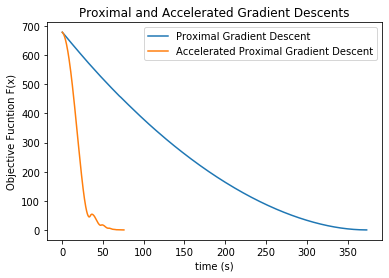

In [891]:
proxGradData = np.asarray(proxGradData)
accelProxGradData = np.asarray(accelProxGradData)
plt.plot(proxGradData[:, 1], proxGradData[:, 0], label = ProxGradDesc().__str__())
plt.plot(accelProxGradData[:, 1], accelProxGradData[:, 0], label = AccelProxGradDesc().__str__())
plt.xlabel('time (s)')
plt.ylabel('Objective Fucntion F(x)')
plt.title('Proximal and Accelerated Gradient Descents')
plt.legend()
plt.show()

## Did not have time to do Coordinate Descent

Question 2
-------------

Pick one algorithm that you want and plot the number of nonzeros in the output of the algorithm against $\lambda$. Explain in a couple of sentences (or less) what do you observe.

Marks: 10

In [842]:
class NumNonZero():
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.epsilon = initParams['epsilon']
        self.beta = initParams['beta0']
        self.t = initParams['t']
        self.logisticRegression = LogisticRegression()
        
    def __str__(self):
        return 'Accelerated Proximal Gradient Descent'
    
    def accelProxAG(self, alpha, y, gradF):
        lambda_ = self.lambda_
        xNext = np.zeros((y.shape[0], 1))
        la = lambda_ * alpha
        u = y - lambda_ * alpha * gradF
        
        xNext[u >= la] = u[u >= la] - la
        xNext[np.abs(u) <= la] = 0
        xNext[u <= -la] = u[u <= -la] + la
        
        return xNext
    
    def accelProxGrad(self, xCurrent, A, b):
        beta = self.beta
        max_iters = 200
        tCurrent = self.t
        yCurrent = xCurrent
        start = time.time()
        for i in range(max_iters):
            gradF, gradB = self.logisticRegression.gradient(xCurrent, A, b, beta)
            alpha = lineSearch(beta, xCurrent, gradF, A, b)
            
            xNext = self.accelProxAG(alpha, yCurrent, gradF)
            tNext = (1 + np.sqrt(1 + 4 * tCurrent ** 2)) / 2
            yCurrent = xNext + ((tCurrent - 1)/tNext) * (xNext - xCurrent)
            
            Gx = (xCurrent - xNext) / alpha
            
            if (np.linalg.norm(Gx) < self.epsilon):
                return xNext, beta
            else:
                xCurrent = xNext
                tCurrent = tNext
                beta -= alpha * gradB
        
        return xNext, beta

In [859]:
lambda_list = np.power(10, np.linspace(-6, 0, 30))

numNon0X = np.zeros_like(lambda_list)

for i in range(len(lambda_list)):
    numNonZero = NumNonZero(lambda_list[i])
    
    print('Lambda =', lambda_list[i])
    print('Starting', numNonZero.__str__(), 'number', i, 'of', len(lambda_list))
    
    start = time.time()
    xAccelProxGrad, betaAccelProxGrad = numNonZero.accelProxGrad(x0, ATrain_news20, bTrain_news20)
    end = time.time() - start
    
    numNon0X[i] = np.count_nonzero(xAccelProxGrad)
    
    print('Done', numNonZero.__str__(), 'number', i, 'of', len(lambda_list), 'in', end, 's')
    print('Number of non zeros:', np.count_nonzero(xAccelProxGrad))
    
    error, accuracy = calcError(xAccelProxGrad, betaAccelProxGrad)
    
    print('Error:', error, 'Accuracy:', accuracy)
    
    print()

Lambda = 1e-06
Starting Accelerated Proximal Gradient Descent number 0 of 30
Done Accelerated Proximal Gradient Descent number 0 of 30 in 0.384655237197876 s
Number of non zeros: 1355187
Error: [0.528] Accuracy: [0.736]

Lambda = 1.6102620275609392e-06
Starting Accelerated Proximal Gradient Descent number 1 of 30
Done Accelerated Proximal Gradient Descent number 1 of 30 in 0.3546900749206543 s
Number of non zeros: 1355187
Error: [0.528] Accuracy: [0.736]

Lambda = 2.592943797404667e-06
Starting Accelerated Proximal Gradient Descent number 2 of 30
Done Accelerated Proximal Gradient Descent number 2 of 30 in 0.3568439483642578 s
Number of non zeros: 1355184
Error: [0.528] Accuracy: [0.736]

Lambda = 4.1753189365604e-06
Starting Accelerated Proximal Gradient Descent number 3 of 30
Done Accelerated Proximal Gradient Descent number 3 of 30 in 0.3671834468841553 s
Number of non zeros: 1355180
Error: [0.528] Accuracy: [0.736]

Lambda = 6.723357536499335e-06
Starting Accelerated Proximal Gradi

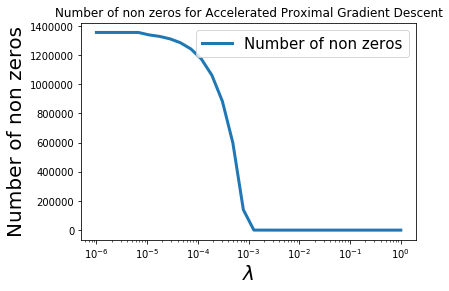

In [860]:
plt.plot(lambda_list, numNon0X, label = "Number of non zeros", linewidth = 3)
plt.legend(fontsize = 15)
plt.xlabel("$\lambda$", fontsize = 20)
plt.ylabel("Number of non zeros", fontsize = 20)
plt.xscale('log')
plt.title('Number of non zeros for Accelerated Proximal Gradient Descent')
plt.show()

From the graph and the printed data, we can see that the number of non zero outputs goes to zero as lambda goes to increases. This is expected since lambda is the weight for the regulization term. As we are minimizing the objective function, the regulization term will be at its lowest when x is all zeros. So if we increase lambda, the minimum of the function will most likely be found when x is all zeros. 

## Label Propagation

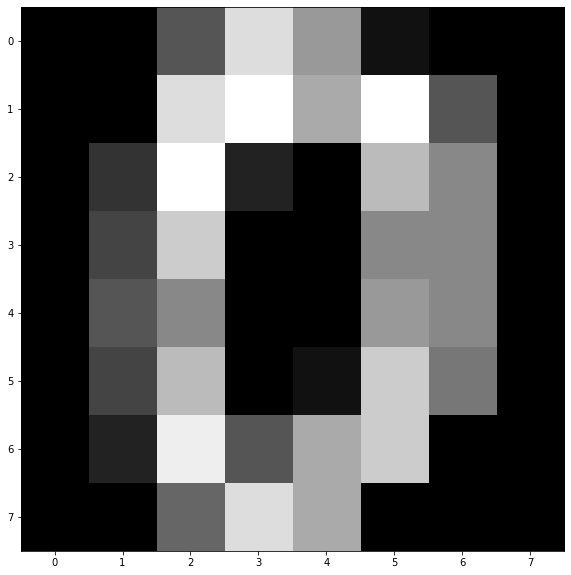

In [892]:
# Load datasets from sklearn
from sklearn import datasets

# Load the digits dataset.
# See here for a distription of this dataset: 
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
digits = datasets.load_digits()

# Briefly, this dataset has 1797 images of digits. The digits are from 0 to 9.
# There are about 180 images per digit.

# digits.data includes the vectorized images of the digits
# digits.target includes the labels of the images
# digits.images includes the images in non-vectorized format

# Example: number 0
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 10))
plt.imshow(digits.images[0], cmap='gray')
plt.show()

Let x_i and x_j be two vectorized images.
Compute their pairwise similarity by
$$ 
w_{ij} = \exp(-\gamma \|x_i-x_j\|_2^2),
$$
where $\gamma$ is parameter tha controls the importance of the distance $\|x_i-x_j\|_2^2$. If $\gamma=1/(2\sigma^2)$ then this is called the Gaussian kernel and $\sigma^2$ represents the variance.
You can compute the similarities by using: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html.
Alterantively, you can compute the pairwise similarities manually, by using the above formula.

Sparsify the graph by setting small values to zero. The thresholding tolerance is a parameter that you will have to tune. Generally, there is a consensus that sparse similarity matrices result in better performance. So, you should expect that, but have in mind that this is only an empirical observation.

In [893]:
# Example
# Pairwise weights matrix
W = sklearn.metrics.pairwise.rbf_kernel(digits.data)

# Remove self-similarity
W = W - np.eye(len(W))

# Sparsify (tune the tolerance parameter for your problem)
tol = 1e-9
W[abs(W) < tol] = 0.0

This dataset provides labels for every image of a digit. However, in this assignment we want to check how the label propagation model works. Use all images, i.e., 1797 images of digits, but use only 10 labels per type of digit, e.g., use the first 10 labels for digit 0, the first 10 labels of digit 1 etc. This means that you should use 100 labels in total out of 1797. Do not use the remaining labels for training the model. The remaining labels will be used only to measure accuracy of the model.

In [894]:
# digits.data includes the vectorized images of the digits
# digits.target includes the labels of the images
# digits.images includes the images in non-vectorized format

def createDataSet(digits, size, numbers = 10):
    knownSetLabel = np.array([])
    knownSetInd = np.array([])
    unknownSetInd = np.array([])
    for i in range(numbers):
        knownSetInd = np.append(knownSetInd, np.where(digits.target == i)[0][: size])
        
        unknownSetInd = np.append(unknownSetInd, np.where(digits.target == i)[0][size :])
    knownSetLabel = np.append(knownSetLabel, digits.target[knownSetInd.astype(int)])
    return knownSetInd, knownSetLabel, unknownSetInd

Question 3
-------------
Train the label propagation model
$$
\mbox{minimize}_{b\in\mathbb{R}^n} \ \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n w_{ij} (b_i -b_j)^2 + \sum_{i=1}^{m-n}\sum_{j=1}^n \bar{w}_{ij} (\bar{b}_i -b_j)^2
$$
using the coordinate method that was discussed in Lecture 14 for the label propagation problem. Make sure that you understand the derivation of the algorithm before you apply it to train the label propagation model.

The output of the algorithm should be the soft labels $b$ for each image. However, these soft labels are not going to be integers (actual labels). Therefore, we have to round the output labels $b$ to get integer labels for each image. One possible way to round the output is to simply find the integer label (possible options 0 to 9) that a soft label is closest to. Then pick this label as the label of the image.

After you label all images, use the function in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html to measure precision, recall and f1_score. You only have to provide the true and the predicted labels when using this function. Do not change the default parameters.

If you want to learn more about precision, recall and f1_score check Wikipedia: 
precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall
f1_score: https://en.wikipedia.org/wiki/F1_score.

Report precision, recall and f1score of your method.

Marks: 20

In [895]:
def labelProp(bBar, bBarI, bI, W, max_iter = 200):
    b = np.random.randint(1, 10, W.shape[0]).astype(float)
    b[bBarI.astype(int)] = bBar
    for i in range(max_iter):
        for j in bI:
            j = int(j)
            b[j] = np.dot(W[:, j], b) / np.sum(W[:, j])
    b = np.round(b).astype(int)
    
    return b

In [896]:
import pprint
bBarI, bBar, bI = createDataSet(digits, 10)
b = labelProp(bBar, bBarI, bI, W)

precision, recall, f1_score, support = sklearn.metrics.precision_recall_fscore_support(digits.target, b)
pd.DataFrame(data = {'Precision': precision, 'Recall': recall, 'f1 Score': f1_score, 'Num of Labels': support})

,Precision,Recall,f1 Score,Num of Labels
0,1.000000,0.994382,0.997183,178
1,0.960000,0.263736,0.413793,182
2,0.593750,0.107345,0.181818,177
3,0.430341,0.759563,0.549407,183
4,0.729167,0.966851,0.831354,181
5,0.541254,0.901099,0.676289,182
6,0.648746,1.000000,0.786957,181
7,0.491124,0.927374,0.642166,179
8,0.466667,0.120690,0.191781,174
9,1.000000,0.055556,0.105263,180


Question 4
-------------

Increase the number of labels that are used in the model from 10 per digit to 20 per digit. Re-train and report precision, recall and f1score of your method. Explain in a couple of sentences what do you observe.

Marks: 5

In [897]:
bBarI, bBar, bI = createDataSet(digits, 20)
b = labelProp(bBar, bBarI, bI, W)

precision, recall, f1_score, support = sklearn.metrics.precision_recall_fscore_support(digits.target, b)
pd.DataFrame(data = {'Precision': precision, 'Recall': recall, 'f1 Score': f1_score, 'Num of Labels': support})

,Precision,Recall,f1 Score,Num of Labels
0,1.000000,0.994382,0.997183,178
1,0.953125,0.335165,0.495935,182
2,0.745614,0.960452,0.839506,177
3,0.659898,0.710383,0.684211,183
4,0.660377,0.966851,0.784753,181
5,0.826389,0.653846,0.730061,182
6,0.628472,1.000000,0.771855,181
7,0.666667,0.927374,0.775701,179
8,0.328000,0.235632,0.274247,174
9,0.950000,0.316667,0.475000,180


## Local Graph Clustering 

In [898]:
import numpy as np

# Import networkx to load the data
import networkx as nx

# Provide the path of the dataset JohnsHopkins55
path = 'JohnsHopkins55.graphml'

# This dataset is a Facebook anonymized dataset on a particular day in September 2005 
# for a student social network at John Hopkins university. The graph is unweighted 
# and it represents ``friendship'' ties. This graph has 5157 nodes and 186572 edges. 
# This dataset comes along with 6 features, i.e., second major, high school, gender, dorm, major index and year. 
# We construct ``ground truth'' clusters by using the features for each node.
# In particular, we consider nodes with the same value of a feature to be a cluster, e.g., students of year 2009. 
# For this assignment we will attempt to find the students of year 2009 using local graph clustering.

# Load the data as a graph
G = nx.read_graphml(path).to_undirected()

# Construct the adjacency matrix
A = nx.adjacency_matrix(G).astype(np.float64)
ALocalGraphCluster = A
# Indices of nodes (students) of class year 2009
# There should be 910 students of class year 2009.
# We will use these students to measure performance of the model
students_of_year_2009 = []
ct = 0
for node in G.nodes(data=True):
    if node[1]['year'] == 2009:
        students_of_year_2009.append(ct)
    ct += 1
print(len(students_of_year_2009))

910


The target cluster is the students of year 2009 in the list: students_of_year_2009.

For this problem you will have to use the coordinate algorithm that was introduced in Lecture 14.

The coordinate algorithm returns a vector $p$. To get an actual cluster from vector $p$ you will have to round the output of the coordinate algorithm using the rounding technique that was discussed in Lecture 14. 

To measure accuracy of the rounded output you can use number of true positives and the number of false positives of the predicted cluster. True positives are the predicted nodes that are also part of class year 2009. False positive are the number of predicted nodes that are not part of the class year 2009.

In [899]:
#A: Adjacency Martix
#degree: array of degrees of each nodes

def localGraphCluster(A, degree, seed, alpha, e, max_iters = 10000):
    n = A.shape[0]
    p = np.zeros(n)
    r = np.zeros(n)
    nodes = {seed}
    r[seed] = 1
    i = 0
    while i < max_iters and len(nodes) > 0:
        u = random.sample(nodes, 1)[0]
        p[u] = p[u] + alpha * r[u]
        v = A[u].indices
        r[v] += (0.5 * (1 - alpha) * r[u]) / degree[u]
        r[u] *= 0.5 * (1 - alpha)
        
        if r[u] < e * degree[u]:
            nodes.remove(u)
        
        nodes.update({i for i in v if r[i] >= e * degree[i]})
        i += 1
    return p

def getCluster(p, A, degree):
    non0Nodes = np.argwhere(p > 0).flatten()
    non0Nodes = non0Nodes[np.argsort(-p[non0Nodes]/degree[non0Nodes])]
    edges = np.zeros_like(p)
    degreeSum = 0
    conductances = []
    
    for i, node in enumerate(non0Nodes):
        neighbours = A[node].indices
        degreeSum += len(neighbours)
        edges[neighbours] = 1
        edges[non0Nodes[: i + 1]] = 0
        conductances.append(sum(edges) / degreeSum)
    cluster = non0Nodes[: np.argmin(conductances) + 1]
    return cluster

Question 5
-------------

1) Report the number of nonzero nodes in the output of the coordinate algorithm (vector $p$) as the tolerance parameter $\epsilon$ goes to zero. In particular, plot the number of nonzeros in the output $p$ against $\epsilon$.
The number of nonzeros should increase as $\epsilon$ goes to zero.

Marks: 10

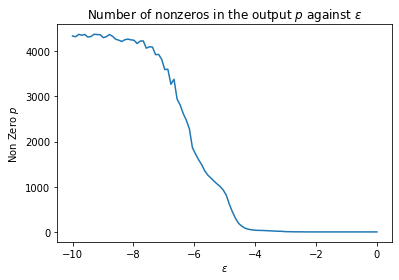

In [900]:
seed = 5000
alpha = 0.1
non0P = []
A = ALocalGraphCluster
#epsilon from 1e-10 to 1
epsilonList = np.power(10, np.linspace(0, -10, 100))
degree = np.array([A[i].sum() for i in range(A.shape[0])], dtype = int)

for epsilon in epsilonList:
    p = localGraphCluster(A, degree, seed, alpha, epsilon)
    non0P.append(p[p > 0].size)
        
plt.figure()
plt.plot(np.log10(epsilonList), non0P)
plt.xlabel('$\epsilon$')
plt.ylabel('Non Zero $p$')
plt.title('Number of nonzeros in the output $p$ against $\epsilon$')
plt.show()

Question 6
-------------

2) Run the coordinate algorithm using as seed node the node with index 5000. Round the output to get an actual cluster back. Measure true positives and false positives of the predicted cluster. Report these two numbers.

Marks: 10

In [901]:
epsilon = 1e-5
seed5000 = 5000
alpha = 0.1
p5000 = localGraphCluster(A, degree, seed5000, alpha, epsilon)
cluster = getCluster(p5000, A, degree)

truePos = 0
falsePos = 0
for i in cluster:
    if i in students_of_year_2009:
        truePos += 1
    else:
        falsePos += 1

print('True and False positives for seed:', seed5000)
print('True Positive:', truePos)
print('False Positive:', falsePos)

True and False positives for seed: 5000
True Positive: 744
False Positive: 71


Question 7
-------------

3) Run the coordinate algorithm using as seed node the node with index 146. Round the output to get an actual cluster back. Measure true positives and false positive of the predicted cluster. Report these two numbers. How do they compare to the results in 2) ? Are they different? If yes, why do you think this might have happened? Explain intuitively in a couple of sentences why you think this might happen.

Marks: 5

In [902]:
seed146 = 146
p146 = localGraphCluster(A, degree, seed146, alpha, epsilon)
cluster = getCluster(p146, A, degree)

truePos = 0
falsePos = 0
for i in cluster:
    if i in students_of_year_2009:
        truePos += 1
    else:
        falsePos += 1
print('True and False positives for seed:', seed146)
print('True Positive:', truePos)
print('False Positive:', falsePos)

True and False positives for seed: 146
True Positive: 572
False Positive: 111


## Compare nodes 5000 and 146
Yes the results for Seed node 5000 and Seed node 146 are indeed different. The number of true positives decrease, and we get more False Positives when we start with node 146. This is because node 146 only has 3 neightbours, thus we miss out on more classes 

## Reccomender System

Download the data matrix $A$ from the webiste https://grouplens.org. Navigate to the dataset tab https://grouplens.org/datasets/movielens/ and download the dataset MovieLens 100K. Read the description of the dataset carefully. 
This dataset includes 5 data matrices $A$. We only need to use one of these in this assignment. In particular, use the dataset u1.base. Use the corresponding testing data u1.test to measure the accuracy of your model. For this question only it's ok if you use the testing data to tune parameters. Ignore the timestap feature in the dataset. We do not need this for this problem.

In [903]:
train = np.loadtxt('ml-100k/u1.base')[:, :3]
test = np.loadtxt('ml-100k/u1.test')[:, :3]

def getA(data, n, m):
    data[:, :2] = data[:, :2] - 1
    A = np.zeros((n, m))
    for i in range(len(data)):
        user = int(data[i][0])
        movie = int(data[i][1])
        rating = data[i][2]
        A[user][movie] = rating
    return A
ATrainRS = getA(train, 943, 1682)
ATestRS = getA(test, 943, 1682)
x0 = np.random.randint(1, 6, ATrainRS.shape)

knownValues = ATrainRS != 0
knownTestValues = ATestRS != 0

Question 8
------------

Solve the penalized problem
$$
\mbox{minimize} \ \lambda \|X\|_* + \sum_{ij \ | \ A_{ij} \ is \ known} (X_{ij} - A_{ij})^2,
$$
where $\|X\|_*$ is the nuclear norm, using proximal gradient descent. This algorithm requires thresholding the singular values of $X$ at each iteration.
You can use https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html (sparse matrices) or https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html (dense matrices).

To check your solution against u1.test, report your score as follows. Let $X$ be the output of the proximal gradient method, let $A'$ and $\Omega'$ be the data matrix and the non-zero entry list for the test data. Then the score is 
$$
\frac{1}{|\Omega'|} \sum_{(i,j)\in\Omega'} | X_{ij} - A_{ij}'|.
$$
In other words, the average absolute deviation of the computed ratings from the predicted ratings. Report your score.

Marks: 15

In [904]:
def prox(lambda_, alpha, xCurrent, gradF):
    z = xCurrent - alpha * gradF
    u, s, vT = np.linalg.svd(z)
    
    s = np.maximum(s - alpha * lambda_, 0)
    
    sDense = np.zeros((u.shape[1], vT.shape[0]))
    sDense[:len(s), :len(s)] = np.diag(s)
    
    xNext = (u.dot(sDense)).dot(vT)
    return xNext, s

def lineSearchRS(xCurrent, A, gradF):
    alpha = initParams['alpha0']
    theta = initParams['theta']
    lambda_ = 50
    
    rs = ReccomenderSystem()
    
    #F(x_k)
    s = np.linalg.svd(xCurrent, compute_uv = False)
    F_x_k = rs.objFunc(xCurrent, A, s)
    
    #l(x_k)
    l_x_k = F_x_k
    
    #x(alpha)
    x_alpha, s = prox(lambda_, alpha, xCurrent, gradF)
    
    #F(x(alpha))
    F_x_alpha = rs.objFunc(x_alpha, A, s)
    
    #l(x(alpha))
    l_x_alpha = rs.gx(x_alpha, s) + rs.fx(xCurrent, A) + (gradF * (x_alpha - xCurrent)).sum()
    
    while (F_x_alpha > F_x_k - theta * (l_x_k - l_x_alpha)):
        alpha /= 2
        
        #x(alpha)
        x_alpha, s = prox(lambda_, alpha, xCurrent, gradF)
        
        #F(x(alpha))
        F_x_alpha = rs.objFunc(x_alpha, A, s)
        
        #l(x(alpha))
        l_x_alpha = rs.gx(x_alpha, s) + rs.fx(xCurrent, A) + (gradF * (x_alpha - xCurrent)).sum()
    
    return alpha

def error(x, ATest):
    x = np.round(x)
    error = np.linalg.norm(x[knownTestValues] - ATest[knownTestValues], 1)/knownTestValues.sum()
    return error

In [905]:
class ReccomenderSystem():
    def __init__(self):
        self.lambda_ = 50 #initParams["lambda_"]
        
    def __str__(self):
        return 'Reccomender System'
    
    def gx(self, X, s):
        lambda_ = self.lambda_ 
        return lambda_ * np.sum(s)
    
    def fx(self, X, A):
        return np.sum((X[knownValues] - A[knownValues]) ** 2)
    
    def objFunc(self, X, A, s):
        g_x = self.gx(A, s)
        f_x = self.fx(X, A)
        return g_x + f_x
    
    def gradient(self, X, A):
        gradF = np.zeros_like(A)
        gradF[knownValues] = 2 * (X[knownValues] - A[knownValues])
        return gradF

In [906]:
def penalizer(xCurrent, A):
    rs = ReccomenderSystem()
    max_iters = 200
    lambda_ = 10
    for i in range(max_iters):
        
        gradF = rs.gradient(xCurrent, A)
        alpha = lineSearchRS(xCurrent, A, gradF)

        xNext, s = prox(lambda_, alpha, xCurrent, gradF)
        if (i % 20 == 0): 
            print('Iteration:', i, 'out of', max_iters, 'iterations')
            print('Objective Function:', rs.objFunc(xNext, A, s))
            
        Gx = (xCurrent - xNext) / alpha
        
        if (np.linalg.norm(Gx) < 1e-2):
            return xNext
        else:
            xCurrent = xNext
                
    return xNext

In [667]:
rs = ReccomenderSystem()
x0[knownValues] = ATrainRS[knownValues]
x = penalizer(x0, ATrainRS)
score = error(x, ATest)
print('Score:', score)

Iteration: 0 out of 200 iterations
Objective Function: 2224034.5471557504
Iteration: 20 out of 200 iterations
Objective Function: 342708.27298988577
Iteration: 40 out of 200 iterations
Objective Function: 332658.91948083654
Iteration: 60 out of 200 iterations
Objective Function: 327585.0407599081
Iteration: 80 out of 200 iterations
Objective Function: 324214.87051402545
Iteration: 100 out of 200 iterations
Objective Function: 321716.4282558738
Iteration: 120 out of 200 iterations
Objective Function: 319755.3231732809
Iteration: 140 out of 200 iterations
Objective Function: 318164.5651491285
Iteration: 160 out of 200 iterations
Objective Function: 316847.3353249789
Iteration: 180 out of 200 iterations
Objective Function: 315742.0705507721
Score: 0.7265


Question 9
------------

Now consider the factorized problem
$$
\mbox{minimize}_{L,R} \ \frac{\lambda}{2} \left(\|L\|_F^2 + \|R\|_F^2\right) + \|W\circ (LR^T-A)\|_F^2
$$
See Lecture 15 about details for this problem. Solve this problem and obtain the matrix $X=LR^T$. Use $X$ as the predicted rating and report your score. For calculating derivatives of matrix functions you can have a look here: https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf. 

Marks: 10

In [907]:
A = ATrainRS
m, n = A.shape
W = np.zeros_like(A)
W[knownValues] = 1
k = 100
L0 = np.random.rand(m, k)
R0 = np.random.rand(n, k)
class FactorizedReccomenderSystem():
    def __init__(self, lambda_):
        self.lambda_ = lambda_
    
    def __str__(self):
        return 'Factorized Reccomender System'
    
    def objFunc(self, L, R, W, A):
        lambda_ = self.lambda_
        Lnorm = np.linalg.norm(L, ord = 'fro') ** 2
        Rnorm = np.linalg.norm(R, ord = 'fro') ** 2
        right = np.linalg.norm(W * (L @ R.T - A), ord = 'fro') ** 2
        return (lambda_ / 2) * (Lnorm + Rnorm) + right

    def gradL(self, L, R, W, A):
        lambda_ = self.lambda_
        return lambda_ * L + 2 * (W * (L @ R.T - A)) @ R

    def gradR(self, L, R, W, A):
        lambda_ = self.lambda_
        return lambda_ * R + 2 * ((W * (L @ R.T - A)).T @ L)

    def LLineSearch(self, L, R, W, A):
        lambda_ = self.lambda_
        alpha = 1
        f_x_k = objFunc(lambda_, L, R, W, A)
        gL = gradL(lambda_, L, R, W, A)
        LNext = L - alpha * gL
        while(objFunc(lambda_, LNext, R, W, A) > f_x_k):
            alpha /= 2
            LNext = L - alpha * gL
        return alpha

    def RLineSearch(self, L, R, W, A):
        lambda_ = self.lambda_
        alpha = 1
        f_x_k = objFunc(lambda_, L, R, W, A)
        gR = gradR(lambda_, L, R, W, A)
        RNext = R - alpha * gR
        while(objFunc(lambda_, L, RNext, W, A) > f_x_k):
            alpha /= 2
            RNext = R - alpha * gR
        return alpha

    def factorizedPenalizer(self, L, R, W, A):
        lambda_ = self.lambda_
        max_iters = initParams['max_iter']
        for i in range(max_iters):
            #Fix L and solve wrt R
            alphaR =  RLineSearch(lambda_, L, R, W, A)
            gR = gradR(lambda_, L, R, W, A)

            R = R - alphaR * gR

            #Fix R and solve wrt L
            alphaL = LLineSearch(lambda_, L, R, W, A)
            gL = gradL(lambda_, L, R, W, A)
            L = L - alphaL * gL

            if (i % 200 == 0):
                print('Iteration:', i, 'out of', max_iters, 'iterations')
                print('Objective Function:', objFunc(lambda_, L, R, W, A))

        return L, R

In [908]:
lambda_ = 10
factorizedReccomenderSystem = FactorizedReccomenderSystem(lambda_)
L, R = factorizedReccomenderSystem.factorizedPenalizer(L0, R0, W, A)
x = L @ R.T
score = error(x, ATest)
print('Score:', score)

Iteration: 0 out of 2000 iterations
Objective Function: 10669077.629436143
Iteration: 200 out of 2000 iterations
Objective Function: 81709.61436792536
Iteration: 400 out of 2000 iterations
Objective Function: 72281.12131890278
Iteration: 600 out of 2000 iterations
Objective Function: 70697.90595178634
Iteration: 800 out of 2000 iterations
Objective Function: 70166.04706762842
Iteration: 1000 out of 2000 iterations
Objective Function: 69894.50762842332
Iteration: 1200 out of 2000 iterations
Objective Function: 69730.00617448597
Iteration: 1400 out of 2000 iterations
Objective Function: 69620.10686353974
Iteration: 1600 out of 2000 iterations
Objective Function: 69541.97711507631
Iteration: 1800 out of 2000 iterations
Objective Function: 69484.5006241859
Score: 0.75265


## Nonnegative Matrix Factorization: facial feature extraction

Dataset consists of 400 faces


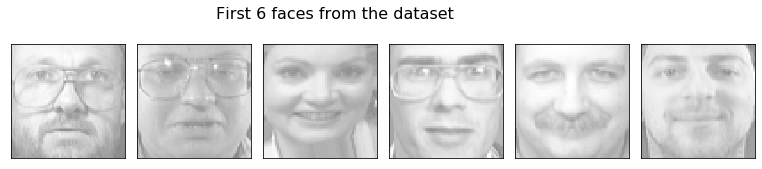

In [909]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

# Useful function for plotting
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.12, 0.05, 0.99, 0.75, 0.04, 0.)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

# Store the vectorized images. Each image has dimensions 64 x 64.
faces = dataset.data

print("Dataset consists of %d faces" % len(faces))
    
plot_gallery("First 6 faces from the dataset", faces[:6], 6, 1)    

In [910]:
class NonNegMatFac():
    def __init__(self, data):
        self.sigma = initParams['sigma']
        self.delta = initParams['delta']
        self.X = data.T
    
    def __str__(self):
        return 'Non-negative Matrix Factorization'
    
    def objFunc(self, W, H):
        X = self.X
        return 0.5 * np.linalg.norm(W @ H - X, ord='fro') ** 2
    
    def gradH(self, W, H):
        X = self.X
        return W.T @ (W @ H - X)
        
    def gradW(self, W, H):
        X = self.X
        return (W @ H - X) @ H.T
    
    def HBar(self, W, H):
        gradH = self.gradH(W, H)
        HBar = np.where(gradH >= 0, H, np.maximum(H, self.sigma * np.ones((H.shape))))
        return HBar
    
    def WBar(self, W, H):
        gradW = self.gradW(W, H)
        WBar = np.where(gradW >= 0, W, np.maximum(W, self.sigma * np.ones((W.shape))))
        return WBar
    
    def bars(self, W, H):
        HBar = self.HBar(W, H)
        WBar = self.WBar(W, H)
        return HBar, WBar

Question 10
--------------

Use the data in "faces" from the above code for the nonnegative matrix factorization problem 
\begin{align*}
\mbox{minimize}_{W,H} &  \ \| WH-X\|_F^2\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j
\end{align*}
where $W\in\mathbb{R}^{m\times r}$ and $H\in\mathbb{R}^{r\times n}$.
Set parameter $r=6$ in the nonnegative factorization problem. Extract the features matrix $W$ by solving the non-negative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 15

In [911]:
def nonNegMatFac(data, r = 6):
    m, n = data.T.shape
    max_iters = initParams['max_iter']
    nnmf = NonNegMatFac(data)
    W = np.random.uniform(0, 1, size = (m, r))
    H = np.random.uniform(0, 1, size = (r, n))
    delta = initParams['delta']
    
    for i in range(max_iters):
        HBar, WBar = nnmf.bars(W, H)
        
        H = H - np.divide(HBar, ((W.T @ W @ HBar) + delta)) * nnmf.gradH(W, H)
        W = W - np.divide(WBar, ((WBar @ H @ HBar.T) + delta)) * nnmf.gradW(W, H)
        
        #Normalize
        S = np.eye(r) / np.sum(W, 0)
        W = W @ S
        H = np.linalg.inv(S) @ H
        if (i % 200 == 0):
            print('Iteration:', i, 'out of', max_iters, 'iterations')
            print('Objective Function:', nnmf.objFunc(W, H))
    return W, H

Iteration: 0 out of 2000 iterations
Objective Function: 25793.681538200235
Iteration: 200 out of 2000 iterations
Objective Function: 7010.241055904761
Iteration: 400 out of 2000 iterations
Objective Function: 6910.017278901699
Iteration: 600 out of 2000 iterations
Objective Function: 6891.487934288256
Iteration: 800 out of 2000 iterations
Objective Function: 6882.712619091637
Iteration: 1000 out of 2000 iterations
Objective Function: 6877.521901832734
Iteration: 1200 out of 2000 iterations
Objective Function: 6873.825724841319
Iteration: 1400 out of 2000 iterations
Objective Function: 6871.02090566685
Iteration: 1600 out of 2000 iterations
Objective Function: 6868.694681355642
Iteration: 1800 out of 2000 iterations
Objective Function: 6866.78572314461


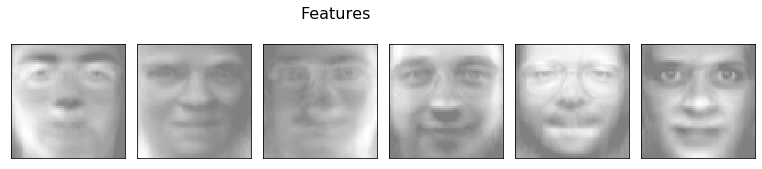

In [912]:
W, H = nonNegMatFac(faces)
plot_gallery("Features", W.T[:6], 6, 1)

Question 11
--------------

Visualize the approximation of the first 6 images using the feature matrix $W$ and the importance matrix $H$. Note that each face can be approaximated by a linear combination of features (columns) from matrix $W$. The positive coefficients of this linear combination are given by matrix $H$.

Marks: 5

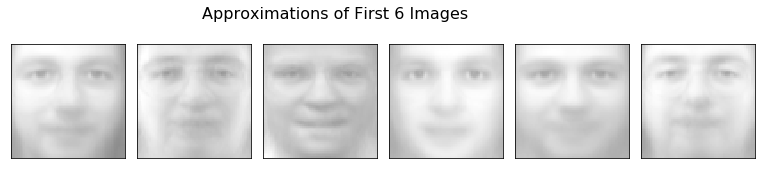

In [913]:
WH = W @ H
plot_gallery('Approximations of First 6 Images', WH.T[:6], 6, 1)

Question 12
--------------

Use matrix $H$ to find the 3 most important features of the first 6 faces. To find the 3 most important features for an image pick the columns of $W$ with the largest coefficients in matrix $H$.

Marks: 5

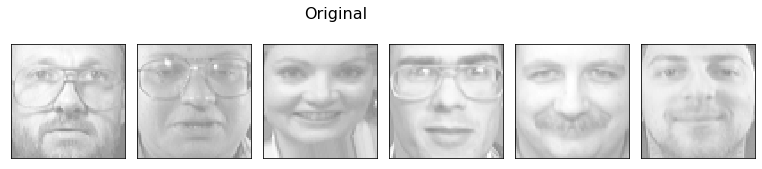

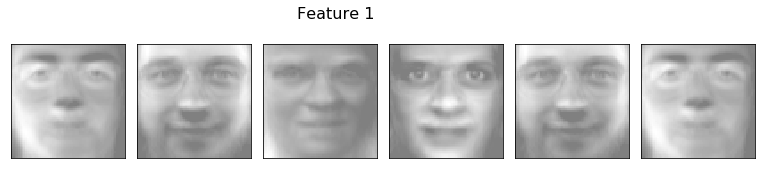

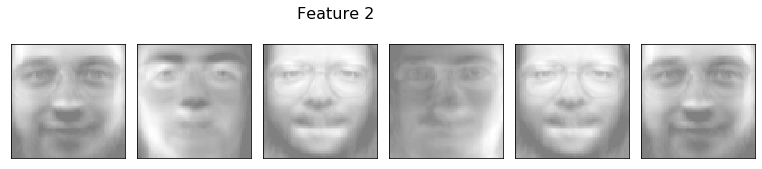

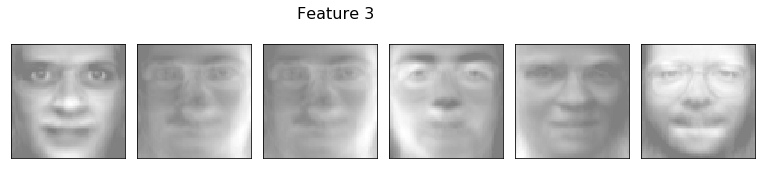

In [914]:
first6 = faces[: 6]
top3Features = []
for i in range(6):
    top3Features.append(np.argsort(-H[:,i])[:3])
top3Features = np.asarray(top3Features)
for i in range(3):
    first6 = np.append(first6, W.T[top3Features.T[i]], 0)
for i in range(4):
    if (i == 0):
        plot_gallery('Original', first6[0: (i + 1) * 6], 6, 1)
    else:
        plot_gallery('Feature ' + str(i), first6[i * 6: (i + 1) * 6], 6, 1)